# Simulate canonical olfaction as in Qin et al. 2019

Here we are following exactly the notation from their paper

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import differential_entropy
from scipy.stats import norm, rankdata
from scipy.special import psi
import cma 

In [16]:
class OlfactorySensing():
    def __init__(self, N=30, n=2, M = 10, sigma_0=1e-2, sigma_c=2): # default parameters taken from figure 2 of their paper, with the exception of sigma_0--they simply say they're in the limit of small sigma_0 . 
        self.N = N
        self.n = n
        self.M = M
        self.sigma_0 = sigma_0
        self.sigma_c = sigma_c
        self.set_sigma() 
        self.set_random_W()

    def draw_c(self): 
        # there is a bigger picture problem here--need a generative model for odor mixtures. 
        # Here we're just following Shanshan's paper. At the very least 1) we can make this a more realistic distribution 2) we can plug in Farhad's data of odor mixtures 3) we can estimate a distribution from that or 4) a full generative model.
        c = np.zeros(self.N)
        non_zero_indices = np.random.choice(self.N, self.n, replace=False)
        # Generate log-normal concentrations for these chosen odorants
        concentrations = np.random.lognormal(mean=0, sigma=self.sigma_c, size=self.n)
        c[non_zero_indices] = concentrations
        # we should think about how to do this better. If you put correlation structure in, it should affect both concentration and presence. Otherwise because n << N your mixtures will in practice be uncorrelated. 
        return c
    
    def draw_cs(self, P):
        self.c = np.zeros((self.N, P))
        for p in range(P): 
            self.c[:, p] = self.draw_c()

    def set_sigma(self): 
        self.sigma = lambda x: x / (1 + x) 

    def set_random_W(self): 
        self.W = np.random.normal(loc=0, scale=1, size=(self.M, self.N))

    def compute_activity(self): 
        self.r = self.sigma(self.W @ self.c) # + np.random.normal(loc=0, scale=self.sigma_0) this isn't right--have to match shape. 

    def compute_entropy_of_r(self):
        entropy = self.compute_sum_of_marginal_entropies() - self.compute_information_of_r()
        self.entropy = entropy 
        return entropy

    def compute_sum_of_marginal_entropies(self):
        marginal_entropies = []
        for m in range(self.M): 
            marginal_entropies.append(differential_entropy(self.r[m, :]))
        return np.sum(marginal_entropies) 
    
    def compute_information_of_r(self): 
        # as in Qin et al. 2019, we use gaussian copula. As far as I can tell, this is nothing more than transforming your data through inverse normal cdf to have marginal gaussian distributions. 
        M, P = self.r.shape  # [dimension, sample size]
        # Step 1: Transform data to approximate standard normal in each dimension
        G = norm.ppf((rankdata(self.r.T, axis=0) / (P + 1)), loc=0, scale=1)
        bias_correction = 0.5 * np.sum(psi((P - np.arange(1, M + 1) + 1) / 2) - np.log(P / 2)) # still need to understand this line! 
        # Step 3: Log determinant using Cholesky decomposition
        cov_matrix = np.cov(G, rowvar=False)
        chol_decomp = np.linalg.cholesky(cov_matrix)
        log_det = np.sum(np.log(np.diag(chol_decomp))) # this should be more stable than taking the product of eigenvalues, which is good
        # Step 4: Mutual information estimate
        I = -(log_det - bias_correction)
        return I
    
    def CMA_ES_objective(self, W_flat): 
        W = W_flat.reshape(self.M, self.N) 
        self.W = W
        self.compute_activity()
        entropy = self.compute_entropy_of_r()
        return -1 * entropy # CMA-ES is minimizing the objective 
        
    def optimize_W(self):
        initial_W = np.random.normal(loc=0, scale=1, size=self.M * self.N)
        sigma = 0.5 
        result = cma.fmin(self.CMA_ES_objective, initial_W, sigma)
        optimized_W = result[0].reshape(self.M, self.N) 
        return optimized_W 
        

In [17]:
os = OlfactorySensing()

os.draw_cs(P=1000)
os.compute_activity()

In [18]:
os.compute_entropy_of_r()

15.634217509411789

In [19]:
os.W.shape

(10, 30)

In [21]:
W = os.optimize_W()

(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 300 (seed=573670, Tue Nov 12 15:43:25 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     21 -1.557551503162211e+01 1.0e+00 4.90e-01  5e-01  5e-01 0:00.1
    2     42 -1.602813770174610e+01 1.0e+00 4.82e-01  5e-01  5e-01 0:00.2
    3     63 -1.586975921490343e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.3
   37    777 -1.901846349995882e+01 1.0e+00 3.94e-01  4e-01  4e-01 0:03.4
   84   1764 -1.862368959223314e+01 1.1e+00 3.45e-01  3e-01  3e-01 0:07.4
  100   2100 -1.858752985007257e+01 1.1e+00 3.29e-01  3e-01  3e-01 0:08.7
  174   3654 -1.966590027642085e+01 1.2e+00 2.59e-01  3e-01  3e-01 0:14.7
  200   4200 -1.967113000382453e+01 1.2e+00 2.39e-01  2e-01  2e-01 0:16.9
  300   6300 -1.977550054890300e+01 1.2e+00 1.74e-01  2e-01  2e-01 0:24.6
  400   8400 -2.074521322782526e+01 1.2e+00 1.47e-01  1e-01  1e-01 0:32.7
  500  10500 -2.056863134151641e+01 1.2e+00 1.24e-01  1e-01  1e-01 0:40.4
  600  12600 -2.0746

KeyboardInterrupt: 

# Simple test: more correlated Gaussians should lead to higher mutual information, hence lower entropy

In [105]:
def compute_information(c, os, P): 
    mean = [0] * 30 
    cov = c * np.ones((30, 30))
    for i in range(cov.shape[0]): 
        cov[i, i] = 1
    os.r = np.random.multivariate_normal(mean, cov, size=P).T 
    I = os.compute_information_of_r()
    return I

I = compute_information(0, os, 1000)

In [107]:
Is = []

for c in np.linspace(0, .9, 10): 
    I = compute_information(c, os, 1000)
    Is.append(I) 

Text(0, 0.5, 'MI(r)')

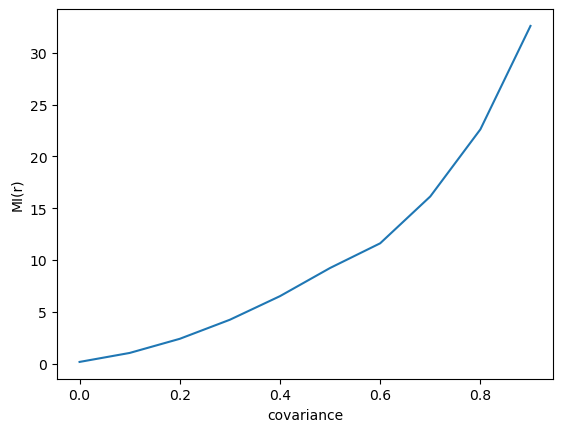

In [110]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, .9, 10), Is)
ax.set_xlabel('covariance') 
ax.set_ylabel('MI(r)')


In [53]:
os.compute_information_of_r()

3.5061792234316362

In [54]:
os.compute_entropy_of_r()

In [55]:
os.entropy

47.00468612694475